In [1]:
pwd()

'c:\\Users\\User\\VSCode\\Pytorch_Lrarning\\conditional-similarity-networks_new'

In [2]:
from __future__ import print_function
import argparse
import os
import sys
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
# from triplet_image_loader import TripletImageLoader
from image_loader import TripletImageLoader
from tripletnet import CS_Tripletnet
from tripletnet_tri import Tripletnet
from visdom import Visdom
import numpy as np
import Resnet_18
from csn import ConditionalSimNet
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
torch.__version__

'1.10.2+cu113'

In [3]:
# model = Resnet_18.resnet18(pretrained=True, embedding_size=64)
# tnet = Tripletnet(model)

In [3]:
model = Resnet_18.resnet18(pretrained=True, embedding_size=64)
csn_model = ConditionalSimNet(model, n_conditions=4, 
embedding_size=64, learnedmask=True, prein=False)

mask_var = csn_model.masks.weight
tnet = CS_Tripletnet(csn_model)

path = r'C:\Users\User\VSCode\Pytorch_Lrarning\conditional-similarity-networks_new\runs\20221114_b50000\model_best.pth.tar'
checkpoint = torch.load(path)
tnet.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [7]:
from torchvision import models
# csn_model.eval()

print(csn_model)

ConditionalSimNet(
  (embeddingnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [8]:
# print(model)

In [10]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

conditions = [0, 1, 2, 3]

test_loader = torch.utils.data.DataLoader(
    TripletImageLoader('data_new', 'FashionProduct', 'filenames.txt', 
        conditions, 'test', n_triplets=160000,
                    transform=transforms.Compose([
                        transforms.Resize(112),
                        transforms.CenterCrop(112),
                        transforms.ToTensor(),
                        normalize,
                ])),
    batch_size=1, shuffle=False)




In [4]:
img = pd.read_csv(r"C:\Users\User\VSCode\Pytorch_Lrarning\conditional-similarity-networks_new\data_new\filenames.txt", sep="/n", header=None)

C:\Users\User\AppData\Local\Temp\ipykernel_888\262676045.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  img = pd.read_csv(r"C:\Users\User\VSCode\Pytorch_Lrarning\conditional-similarity-networks_new\data_new\filenames.txt", sep="/n", header=None)


In [5]:
## funtion zone

## embed
def EmbedF(c):

    emb = []


    for i in range(5000):

        im = Image.open(r"C:\Users\User\VSCode\Pytorch_Lrarning\conditional-similarity-networks_new\data_new\FashionProduct\\"+img[0][i]).convert('RGB')
        # print(im.size)

        transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomCrop(112),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
        ])

        im_trns = transform(im).unsqueeze(0)
        # print(im_trns.size())

        ## condition
        ## 0 : season
        ## 1 : gender
        ## 2 : usage
        ## 3 : category
        tnet.load_state_dict(checkpoint['state_dict'])
        tnet.eval()
        
        embedded_x, masknorm_norm_x, embed_norm_x, tot_embed_norm_x = tnet.embeddingnet(im_trns, torch.as_tensor([int(c)]))
        x = torch.flatten(embedded_x).detach().numpy()
    
        emb.append(x)
        
    return emb

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# from matplotlib.cbook import get_sample_data


## plot_images_in_2d
def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()
    
## show_tsne    
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(32, 20, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.show()
    

## tsne_to_grid_plotter_manual    
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 3000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(32, 20, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.show()

In [6]:
emb_gender = EmbedF(0)
# print('season done !')
emb_category = EmbedF(1)
# print('gender done !!')
emb_colour = EmbedF(2)
# print('usage done !!!')
emb_type = EmbedF(3)
# print('category done !!!!')


In [17]:
# tnet.eval()
# for batch_idx, (data1, data2, data3, c) in enumerate(test_loader):
#     data1, data2, data3, c = Variable(data1), Variable(data2), Variable(data3), Variable(c)
#     c_test = c
#     dista, distb, _, embed_norm, _ = tnet(data1, data2, data3, c)
# E = []

# csn_model.eval()
# for batch_idx, (data1, c) in enumerate(test_loader):
#     data1, c = Variable(data1), Variable(c)
#     c_test = c
#     emb, _, _, _ = csn_model(data1, c)
#     E.append(emb)


# embedded_x, masknorm_norm_x, embed_norm_x, tot_embed_norm_x = tnet.embeddingnet(im_trns, torch.as_tensor(conditions))

In [29]:
e = np.array(emb_type)

In [8]:
# tnet.embeddingnet

In [9]:
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

In [31]:
tsne = manifold.TSNE(n_components=2, metric='euclidean').fit_transform(e)

# pca = manifold.TSNE(n_components=2, metric='euclidean', init='pca').fit_transform(e)

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [11]:
apparel = pd.read_excel(r'C:\Users\User\VSCode\Pytorch_Lrarning\conditional-similarity-networks_new\apparel.xlsx')
apparel.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName',
       'Unnamed: 10', 'Unnamed: 11', 'image'],
      dtype='object')

In [34]:
apparel.articleType[:5000].value_counts()

Tshirts               1647
Shirts                 770
Kurtas                 463
Tops                   422
Briefs                 168
Jeans                  137
Bra                    128
Shorts                 124
Trousers               118
Dresses                109
Sarees                  96
Sweatshirts             72
Track Pants             66
Tunics                  59
Innerwear Vests         54
Kurtis                  52
Capris                  52
Sweaters                51
Jackets                 48
Trunk                   40
Skirts                  37
Nightdress              37
Leggings                34
Night suits             26
Lounge Pants            26
Dupatta                 25
Boxers                  15
Patiala                 11
Lounge Shorts           11
Camisoles               11
Tracksuits              11
Suspenders              10
Rain Jacket              8
Salwar and Dupatta       6
Bath Robe                6
Jumpsuit                 5
Salwar                   5
S

<AxesSubplot:xlabel='Feature_1', ylabel='Feature_2'>

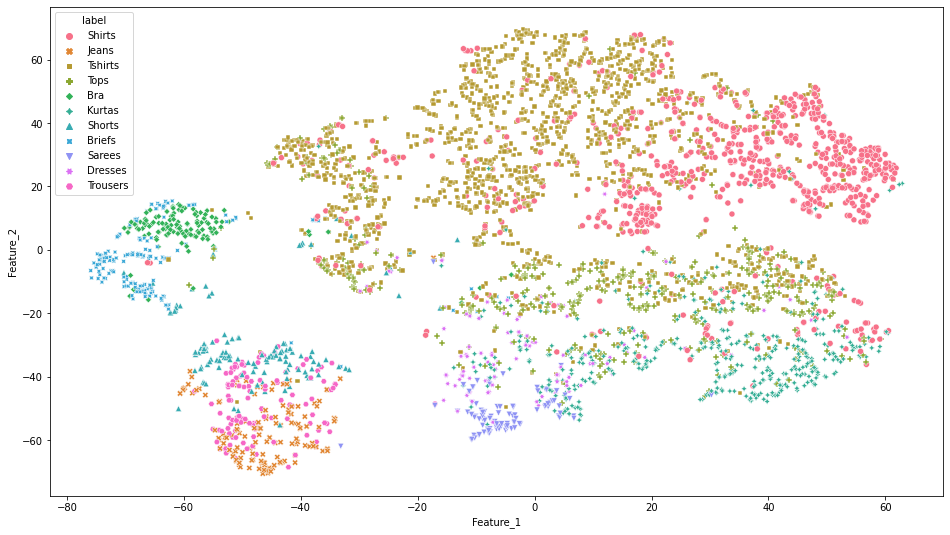

In [35]:
import seaborn as sns

FS = (16, 9)
fig, ax = plt.subplots(figsize=FS)

df = pd.DataFrame(dict(Feature_1=tsne[:,0], Feature_2=tsne[:,1], label=apparel.articleType[:5000], imgpath=apparel.image[:5000]))
df['imgpath'] = df.apply(lambda row: "C:/Users/User/VSCode/Pytorch_Lrarning/conditional-similarity-networks_new/data_new/FashionProduct/" + str(row['imgpath']), axis=1)

# df = df[(df.label == 'Blue') | (df.label == 'Black') | (df.label == 'White') |
#         (df.label == 'Grey') | (df.label == 'Green') | (df.label == 'Red') | (df.label == 'Navy Blue') |
#         (df.label == 'Pink') | (df.label == 'Purple') | (df.label == 'Brown') | (df.label == 'Yellow')].reset_index(drop=True)

df = df[(df.label == 'Tshirts') | (df.label == 'Shirts') | (df.label == 'Kurtas') |
        (df.label == 'Tops') | (df.label == 'Briefs') | (df.label == 'Jeans') | (df.label == 'Bra') |
        (df.label == 'Shorts') | (df.label == 'Trousers') | (df.label == 'Dresses') | (df.label == 'Sarees')].reset_index(drop=True)

sns.scatterplot(data=df,  x="Feature_1", y="Feature_2", hue="label", style="label")

In [23]:
df.label == 'Blue'

0       False
1        True
2       False
3       False
4       False
        ...  
4995    False
4996    False
4997    False
4998     True
4999    False
Name: label, Length: 5000, dtype: bool

In [15]:
# from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# # from matplotlib.cbook import get_sample_data


# def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
#     if axis is None:
#         axis = plt.gca()
#     x, y = np.atleast_1d(x, y)
#     for x0, y0, image_path in zip(x, y, image_paths):
#         image = Image.open(image_path)
#         image.thumbnail((100, 100), Image.ANTIALIAS)
#         img = OffsetImage(image, zoom=zoom)
#         anno_box = AnnotationBbox(img, (x0, y0),
#                                   xycoords='data',
#                                   frameon=False)
#         axis.add_artist(anno_box)
#     axis.update_datalim(np.column_stack([x, y]))
#     axis.autoscale()

In [16]:
# def show_tsne(x, y, selected_filenames):
#     fig, axis = plt.subplots()
#     fig.set_size_inches(32, 20, forward=True)
#     plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
#     plt.show()

In [17]:
# df.imgpath.head()

0    C:/Users/User/VSCode/Pytorch_Lrarning/conditio...
1    C:/Users/User/VSCode/Pytorch_Lrarning/conditio...
2    C:/Users/User/VSCode/Pytorch_Lrarning/conditio...
3    C:/Users/User/VSCode/Pytorch_Lrarning/conditio...
4    C:/Users/User/VSCode/Pytorch_Lrarning/conditio...
Name: imgpath, dtype: object

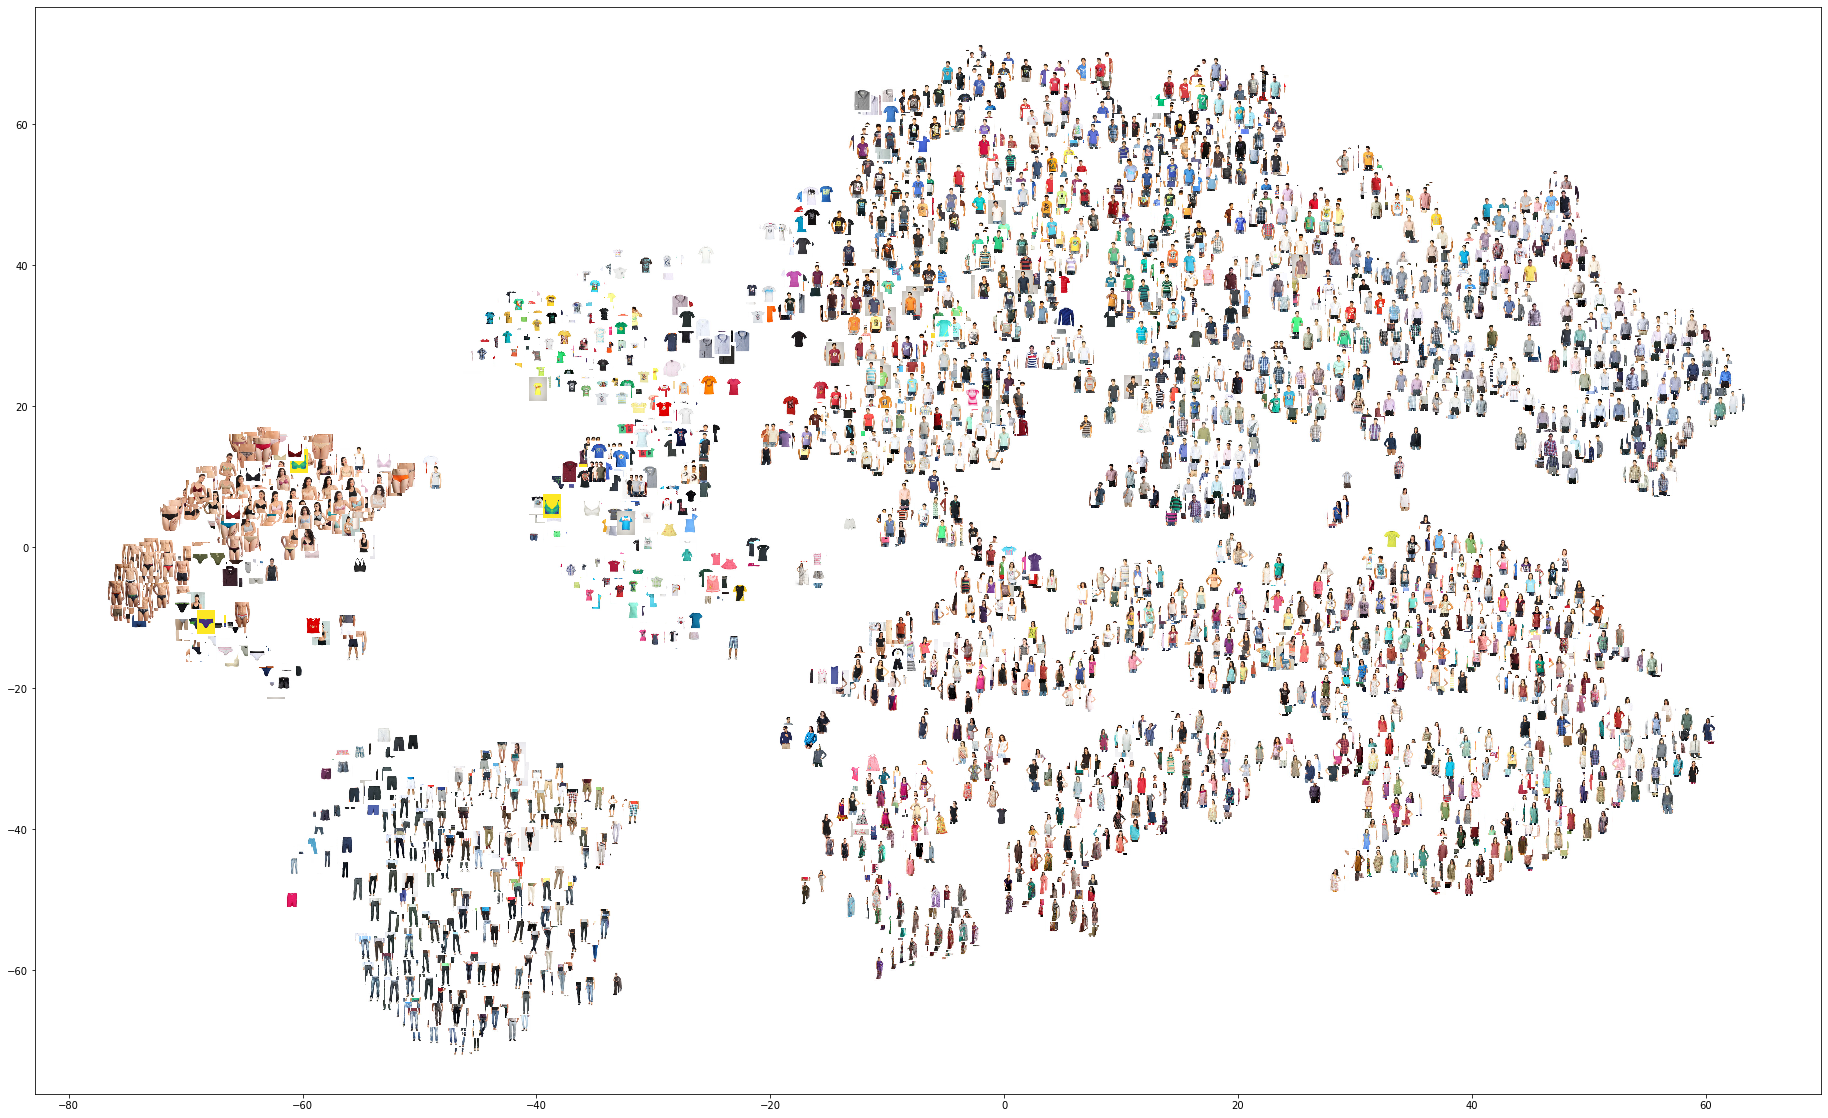

In [36]:
show_tsne(df.Feature_1, df.Feature_2, df.imgpath)

In [19]:
# def tsne_to_grid_plotter_manual(x, y, selected_filenames):
#     S = 3000
#     s = 100
#     x = (x - min(x)) / (max(x) - min(x))
#     y = (y - min(y)) / (max(y) - min(y))
#     x_values = []
#     y_values = []
#     filename_plot = []
#     x_y_dict = {}
#     for i, image_path in enumerate(selected_filenames):
#         a = np.ceil(x[i] * (S - s))
#         b = np.ceil(y[i] * (S - s))
#         a = int(a - np.mod(a, s))
#         b = int(b - np.mod(b, s))
#         if str(a) + "|" + str(b) in x_y_dict:
#             continue
#         x_y_dict[str(a) + "|" + str(b)] = 1
#         x_values.append(a)
#         y_values.append(b)
#         filename_plot.append(image_path)
#     fig, axis = plt.subplots()
#     fig.set_size_inches(32, 20, forward=True)
#     plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
#     plt.show()

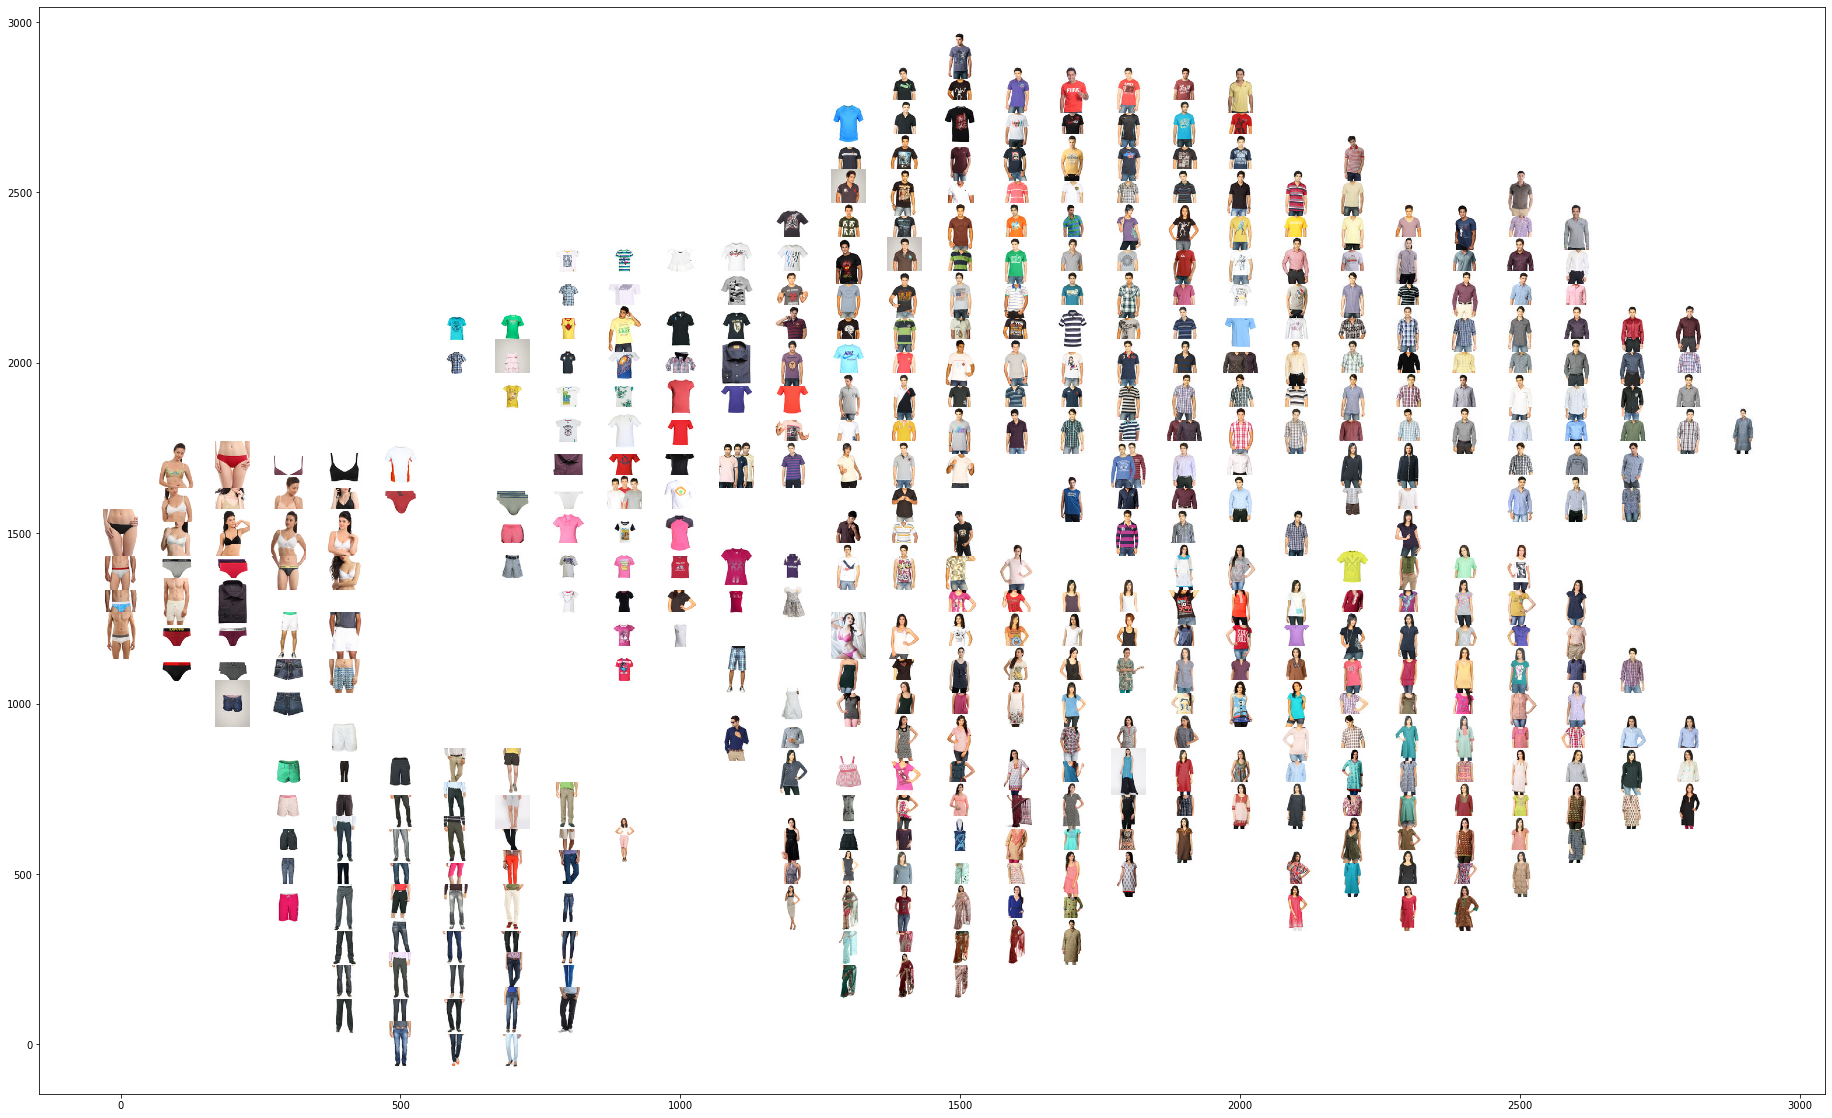

In [37]:
tsne_to_grid_plotter_manual(df.Feature_1, df.Feature_2, df.imgpath)

In [7]:
im = Image.open(r"C:\Users\User\VSCode\Pytorch_Lrarning\conditional-similarity-networks_new\data_new\FashionProduct\\"+img[0][1]).convert('RGB')
# print(im.size)

transform = transforms.Compose([
    transforms.Resize(112),
    transforms.RandomCrop(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

im_trns = transform(im).unsqueeze(0)
# print(im_trns.size())

embedded_x, masknorm_norm_x, embed_norm_x, tot_embed_norm_x = tnet.embeddingnet(im_trns, torch.as_tensor([3]))


In [4]:
import PIL.Image as Image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
imagepath=df.imgpath[10]

    
# read image with PIL module
img_pil = Image.open(imagepath, mode='r')
img_pil = img_pil.convert('RGB')
print(img_pil.size)
img_pil


NameError: name 'df' is not defined

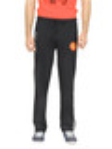

In [52]:
size = 112
transform =  transforms.Resize(size)
new_img = transform(img_pil)
new_img

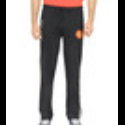

In [53]:
size = 125
transform = transforms.Compose([
    transforms.CenterCrop(size)
])
new_img = transform(new_img)
new_img

In [58]:
im = Image.open(r"C:\Users\User\VSCode\Pytorch_Lrarning\conditional-similarity-networks_new\data_new\FashionProduct\\"+img[0][1]).convert('RGB')
# print(im.size)

transform = transforms.Compose([
    transforms.Resize(112),
    transforms.RandomCrop(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

im_trns = transform(im).unsqueeze(0)
# print(im_trns.size())

## condition
## 0 : season
## 1 : gender
## 2 : usage
## 3 : category
tnet.load_state_dict(checkpoint['state_dict'])
tnet.eval()

embedded_x, masknorm_norm_x, embed_norm_x, tot_embed_norm_x = tnet.embeddingnet(im_trns, torch.as_tensor([int(0)]))

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Unnamed: 10,Unnamed: 11,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,NaN,NaN,myntradataset/fashion/images/15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,NaN,NaN,myntradataset/fashion/images/39386.jpg
2,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,NaN,NaN,myntradataset/fashion/images/21379.jpg
3,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,NaN,NaN,myntradataset/fashion/images/53759.jpg
4,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,NaN,NaN,myntradataset/fashion/images/1855.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21280,30614,Men,Apparel,Topwear,Tshirts,Black,Summer,2012.0,Sports,Nike Men Striped Black Jersey,NaN,NaN,myntradataset/fashion/images/30614.jpg
21281,13496,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Chimp Men Teja Main Hoon Blue Tshirts,NaN,NaN,myntradataset/fashion/images/13496.jpg
21282,12544,Women,Apparel,Topwear,Tshirts,Peach,Fall,2011.0,Casual,Tantra Women Printed Peach T-shirt,NaN,NaN,myntradataset/fashion/images/12544.jpg
21283,42234,Women,Apparel,Topwear,Tops,Blue,Summer,2012.0,Casual,Sepia Women Blue Printed Top,NaN,NaN,myntradataset/fashion/images/42234.jpg


In [13]:
im = Image.open(r"C:\Users\User\VSCode\Pytorch_Lrarning\conditional-similarity-networks_new\data_new\FashionProduct\\"+img[0][1]).convert('RGB')
    # print(im.size)

transform = transforms.Compose([
        transforms.Resize(112),
        transforms.RandomCrop(112),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

im_trns = transform(im).unsqueeze(0)
    # print(im_trns.size())

    ## condition
    ## 0 : season
    ## 1 : gender
    ## 2 : usage
    ## 3 : category
tnet.load_state_dict(checkpoint['state_dict'])
tnet.eval()

embedded_x = csn_model.embeddingnet(im_trns)
mask = csn_model.masks(torch.as_tensor([int(0)]))
# masked_embedding = embedded_x * mask

In [17]:
print(csn_model.masks(torch.as_tensor([int(0)])).size())
csn_model.masks(torch.as_tensor([int(0)]))


torch.Size([1, 64])


tensor([[-4.1305e-04,  7.6121e-01, -3.7999e-04,  4.6545e-01, -3.1194e-01,
         -3.7188e-04, -3.4237e-04, -4.5379e-04, -4.4462e-04,  7.9273e-01,
          9.5162e-01, -2.7183e-04, -3.1049e-04, -3.6539e-04,  9.7048e-01,
         -3.5567e-04,  1.8055e-01, -3.2843e-04, -4.0309e-04, -2.9540e-04,
          6.1789e-01, -3.7228e-04, -4.2461e-04, -3.4439e-04,  1.8281e+00,
         -3.4200e-04, -3.4935e-04,  4.5273e-02, -3.4868e-04, -4.2356e-04,
         -3.2570e-04, -3.7083e-04, -6.0878e-02, -3.5948e-04, -3.2728e-04,
         -1.6981e-01, -3.7385e-04, -6.5315e-01, -3.9212e-04, -3.3521e-04,
         -3.5284e-04,  3.9787e-01, -3.7909e-04, -4.0885e-02, -2.5734e-02,
          2.0263e+00, -4.5737e-04, -3.7162e-04,  2.5836e-01, -2.7931e-04,
         -4.2668e-04, -3.0557e-04, -4.0850e-04,  1.8325e+00, -4.0120e-04,
         -4.4313e-04,  8.9650e-02,  7.8785e-01, -3.2389e-04,  4.1931e-01,
         -3.1166e-04, -4.2685e-04, -3.1629e-04, -3.9654e-04]],
       grad_fn=<EmbeddingBackward0>)

In [5]:
torch.as_tensor(torch.as_tensor([int(0), int(1), int(2), int(3)]))

tensor([0, 1, 2, 3])

'1.10.2+cu113'